# **S3E26: Prediction of Cirrhosis Outcomes**

Table of Contents:
* [About the Project](#1)
* [About the Data](#2)
* [Set Up](#3)
* [EDA](#4)
* [Modeling w/XGB Classifier](#5)
* [Submission](#6)
* [References](#R)

<a id="1"></a>
# **About the Project**

This project is part of Kaggle's [Playground Series](https://www.kaggle.com/competitions/playground-series-s3e26) (Season 3, Episode 26). The main goal of this project is to use a multi-class approach to predict the outcomes of patients with cirrhosis. Broadly speaking, cirrhosis is a condition in which the liver is severely scarred due to excessive liver injury. This permanent scarring can ultimately lead to liver failure and thus can be fatal. For this project, the cirrhosis will lead to three possible outcomes: 
- 1) The patient was alive
- 2) The patient was alive due to a liver transplant
- 3) The patient was deceased

This project was also inspired by many other works for this competition. I will be sure to note any inspirational works in my References section. 

<a id="2"></a>
# **About the Data**

The dataset used for this project and Kaggle competition was generated from an actual [Cirrhosis Patient Survival Prediction](https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction) dataset. Thus, the dataset used here is a synthetically generated dataset. The target variable for this project is the categorical variable 'Status'. This variable has the following three categories, which reflect the patient outcomes noted above:
- C: The patient was alive at N_Days
- CL: The patient was alive (due to a liver transplant) at N_Days
- D: The patient was deceased at N_Days

The dataset provided by Kaggle includes the following three .cvs files:
- sample_submission
- test
- train

This dataset has the following license for public use: [Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/). 

<a id="3"></a>
# **Set Up**

In [1]:
# Loading necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
import optuna
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

In [2]:
# Loading in the dataset
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv', index_col = 'id')
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
test_id = test['id']
test.drop('id', axis=1, inplace=True)

<a id="4"></a>
# **EDA**

## **Viewing the 'train' Dataset**

In [3]:
# Viewing the first 10 entries in train dataset
train.head(10)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
5,703,D-penicillamine,19270,F,N,Y,N,N,0.6,227.0,3.46,34.0,6456.2,60.63,68.0,213.0,11.5,3.0,D
6,1300,Placebo,17703,F,N,N,N,N,1.0,328.0,3.35,43.0,1677.0,137.95,90.0,291.0,9.8,3.0,C
7,1615,Placebo,21281,F,N,Y,N,N,0.6,273.0,3.94,36.0,598.0,52.70,214.0,227.0,9.9,3.0,C
8,2050,D-penicillamine,20684,F,N,N,N,N,0.7,360.0,3.65,72.0,3196.0,94.55,154.0,269.0,9.8,2.0,C


In [4]:
# Viewing a summary description of the train dataset
sum_desc = pd.DataFrame(index = list(train))
sum_desc['Dtype'] = train.dtypes
sum_desc['Count'] = train.count()
sum_desc['#Unique'] = train.nunique()
sum_desc['%Unique'] = sum_desc['#Unique'] / len(train) * 100
sum_desc['#Null'] = train.isnull().sum()
sum_desc['%Null'] = sum_desc['#Null'] / len(train) * 100
sum_desc['Min'] = train.min()
sum_desc['Max'] = train.max()
sum_desc

,Dtype,Count,#Unique,%Unique,#Null,%Null,Min,Max
N_Days,int64,7905,461,5.831752,0,0.0,41,4795
Drug,object,7905,2,0.025300,0,0.0,D-penicillamine,Placebo
Age,int64,7905,391,4.946237,0,0.0,9598,28650
Sex,object,7905,2,0.025300,0,0.0,F,M
Ascites,object,7905,2,0.025300,0,0.0,N,Y
Hepatomegaly,object,7905,2,0.025300,0,0.0,N,Y
Spiders,object,7905,2,0.025300,0,0.0,N,Y
Edema,object,7905,3,0.037951,0,0.0,N,Y
Bilirubin,float64,7905,111,1.404175,0,0.0,0.3,28.0
Cholesterol,float64,7905,226,2.858950,0,0.0,120.0,1775.0


Above, we can see the structure of the train dataset. In total, there are 19 columns (excluding the 'id' column, which is now the index column) and 7905 rows. Thus, there are 18 predictors and the sole target variable 'Status'. Furthermore, we can see that this dataset has no null values. Lastly, we can also see that many of the columns have an 'object' datatype. These will be changed to 'int64' with LabelEncoder.

## **Viewing the 'test' Dataset**

In [5]:
# Viewing the first 10 entries in test dataset
test.head(10)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0
5,1433,D-penicillamine,20510,F,N,N,N,N,0.8,198.0,3.94,38.0,911.0,57.35,56.0,280.0,9.8,1.0
6,1785,Placebo,19060,F,N,N,N,N,0.4,273.0,3.65,25.0,671.0,84.00,177.0,284.0,9.9,3.0
7,1925,D-penicillamine,19994,F,N,Y,N,S,1.8,244.0,3.26,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
8,41,D-penicillamine,24064,F,Y,Y,N,N,17.9,178.0,2.10,220.0,705.0,338.00,229.0,62.0,12.9,4.0
9,1765,D-penicillamine,28650,M,N,Y,N,S,6.4,243.0,3.35,380.0,983.0,158.10,154.0,97.0,11.2,2.0


In [6]:
# Viewing a summary description of the test dataset
sum_desc2 = pd.DataFrame(index = list(test))
sum_desc2['Dtype'] = test.dtypes
sum_desc2['Count'] = test.count()
sum_desc2['#Unique'] = test.nunique()
sum_desc2['%Unique'] = sum_desc2['#Unique'] / len(test) * 100
sum_desc2['#Null'] = test.isnull().sum()
sum_desc2['%Null'] = sum_desc2['#Null'] / len(test) * 100
sum_desc2['Min'] = test.min()
sum_desc2['Max'] = test.max()
sum_desc2

,Dtype,Count,#Unique,%Unique,#Null,%Null,Min,Max
N_Days,int64,5271,409,7.759438,0,0.0,41,4795
Drug,object,5271,2,0.037943,0,0.0,D-penicillamine,Placebo
Age,int64,5271,363,6.886739,0,0.0,9598,28650
Sex,object,5271,2,0.037943,0,0.0,F,M
Ascites,object,5271,2,0.037943,0,0.0,N,Y
Hepatomegaly,object,5271,2,0.037943,0,0.0,N,Y
Spiders,object,5271,2,0.037943,0,0.0,N,Y
Edema,object,5271,3,0.056915,0,0.0,N,Y
Bilirubin,float64,5271,108,2.048947,0,0.0,0.3,28.0
Cholesterol,float64,5271,222,4.211725,0,0.0,120.0,1775.0


Above, we can see the structure of the test dataset. Here, this dataset includes the 18 predictors but excludes the target variable 'Status'. There are 18 columns with 5271 rows of data. Again, several of the predictors have the datatype 'object', which will be changed below.

## **Converting Object-Type Columns to Numerical**

In [7]:
# Converting Object-Type Columns to Numerical (train)
objects = train.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in objects:
    train[col] = label_encoder.fit_transform(train[col])

In [8]:
# Verifying train column types
train.dtypes

N_Days             int64
Drug               int64
Age                int64
Sex                int64
Ascites            int64
Hepatomegaly       int64
Spiders            int64
Edema              int64
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status             int64
dtype: object

In [9]:
# Converting Object-Type Columns to Numerical (test)
objects2 = test.select_dtypes(include=['object']).columns
for col in objects2:
    test[col] = label_encoder.fit_transform(test[col])

In [10]:
# Verifying test column types
test.dtypes

N_Days             int64
Drug               int64
Age                int64
Sex                int64
Ascites            int64
Hepatomegaly       int64
Spiders            int64
Edema              int64
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

Above, we can see that both train and test datasets no longer have any variables with the 'object' datatype. This should make further analyses and modeling easier.

## **Distribution of Feature Variables**

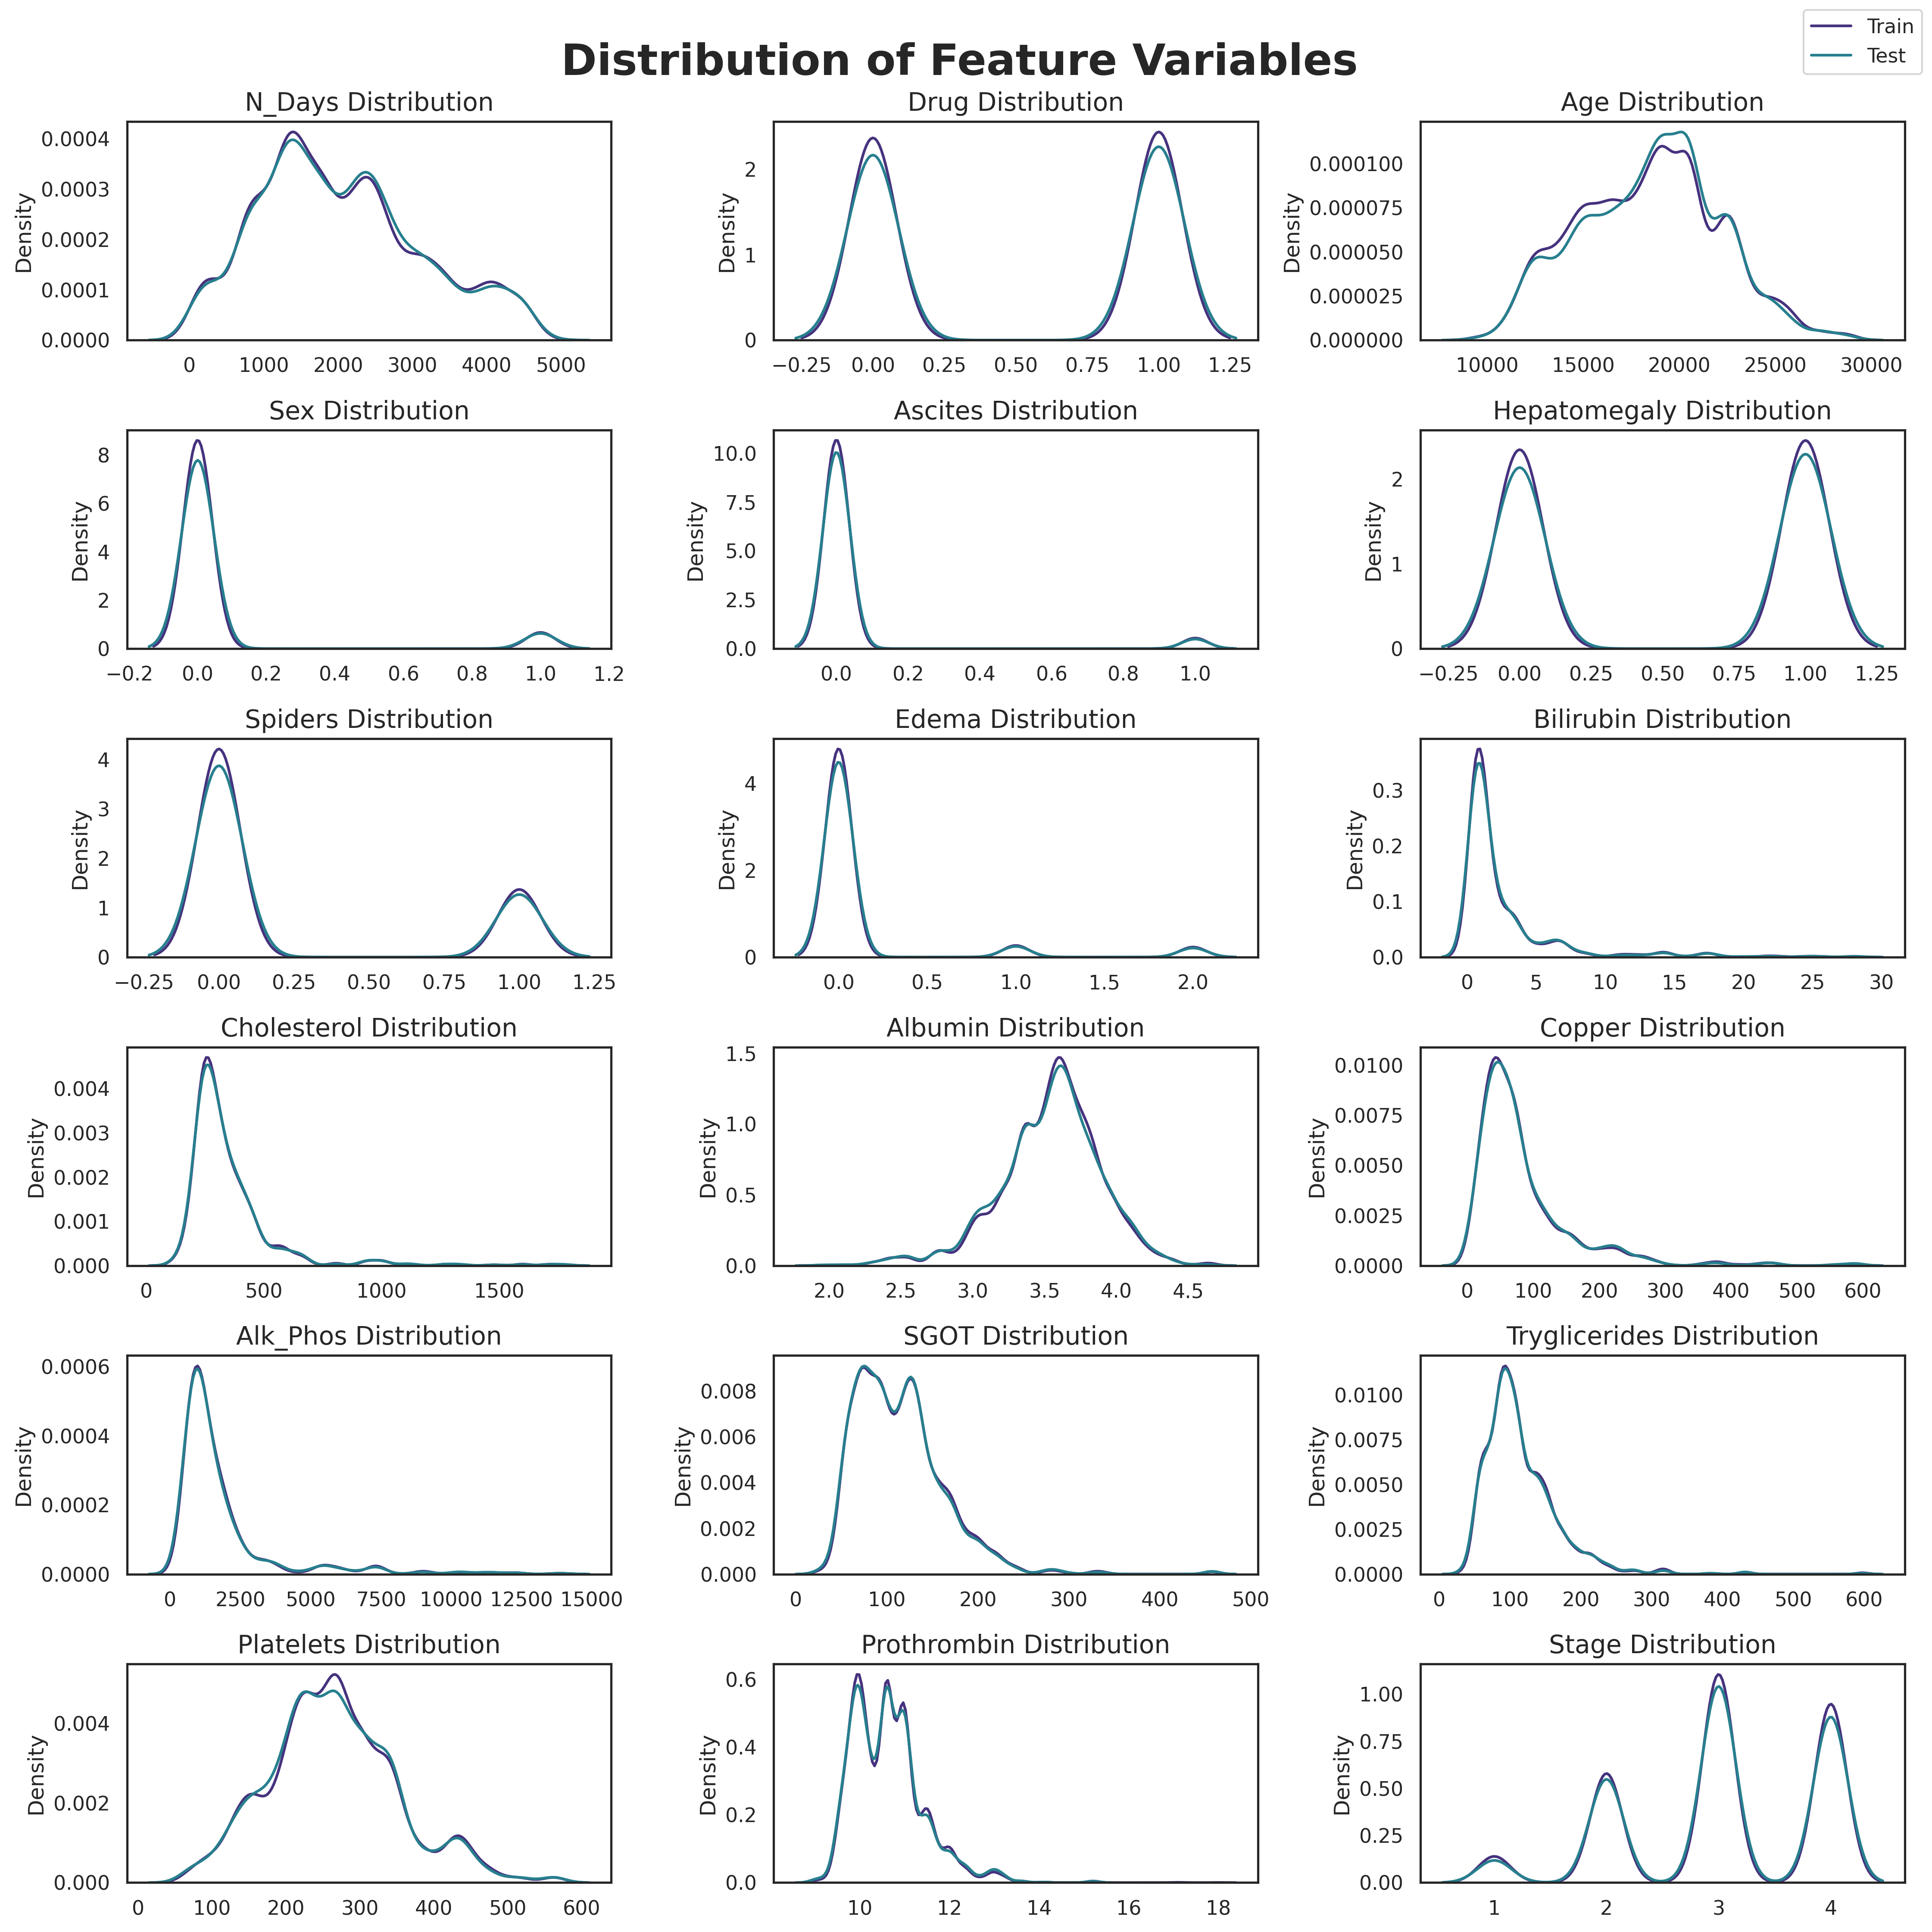

In [11]:
# Plotting distributions of feature variables
fig, ax = plt.subplots(6, 3, figsize = (15, 15), dpi = 300)
ax = ax.flatten()
features = test.columns

for i, column in enumerate(features):
        
    sns.kdeplot(train[column], ax=ax[i], color=pal[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal[2], warn_singular = False)
    
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Feature Variables', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

Above, we can see the distributions for each feature variable. At a glance, many of these variables do not have a balanced distribution. For example, N_days is more densly distributed at days 1000 to 2000, and has much less density at higher numbers of days. Another example of this imbalance can be seen in Sex. Here, there are far more females than males. 

More evenly distributed variables include Drug (Placebo vs D-penicillamine) and Hepatomegaly (Yes vs No). 

## **Distribution of Target Variable**

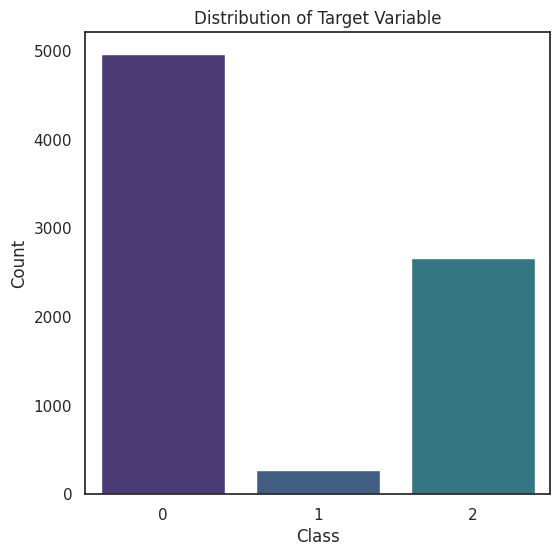

In [12]:
# Plotting distribution of target variable
plt.figure(figsize=(6, 6))
sns.countplot(x='Status', data=train)
plt.title('Distribution of Target Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Above, we can see the distribution of the target variable Status. The numerical classes 0,1, and 2 correspond to the original statuses C, CL, and D, respectively. Here, we can see that the majority of outcomes are C, i.e. the patient was alive after N_Days. The second largest distribution of outcomes is D, i.e. the patient was deceased after N_Days. This class is roughly half of the C class. Lastly, there are very few instances of class CL, i.e. the patient was alive due to a liver transplant after N_Days. From this, we can conclude that the vast majority of patients had lived, but only a few had lived due to a liver transplant. 

## **Correlation of Features**

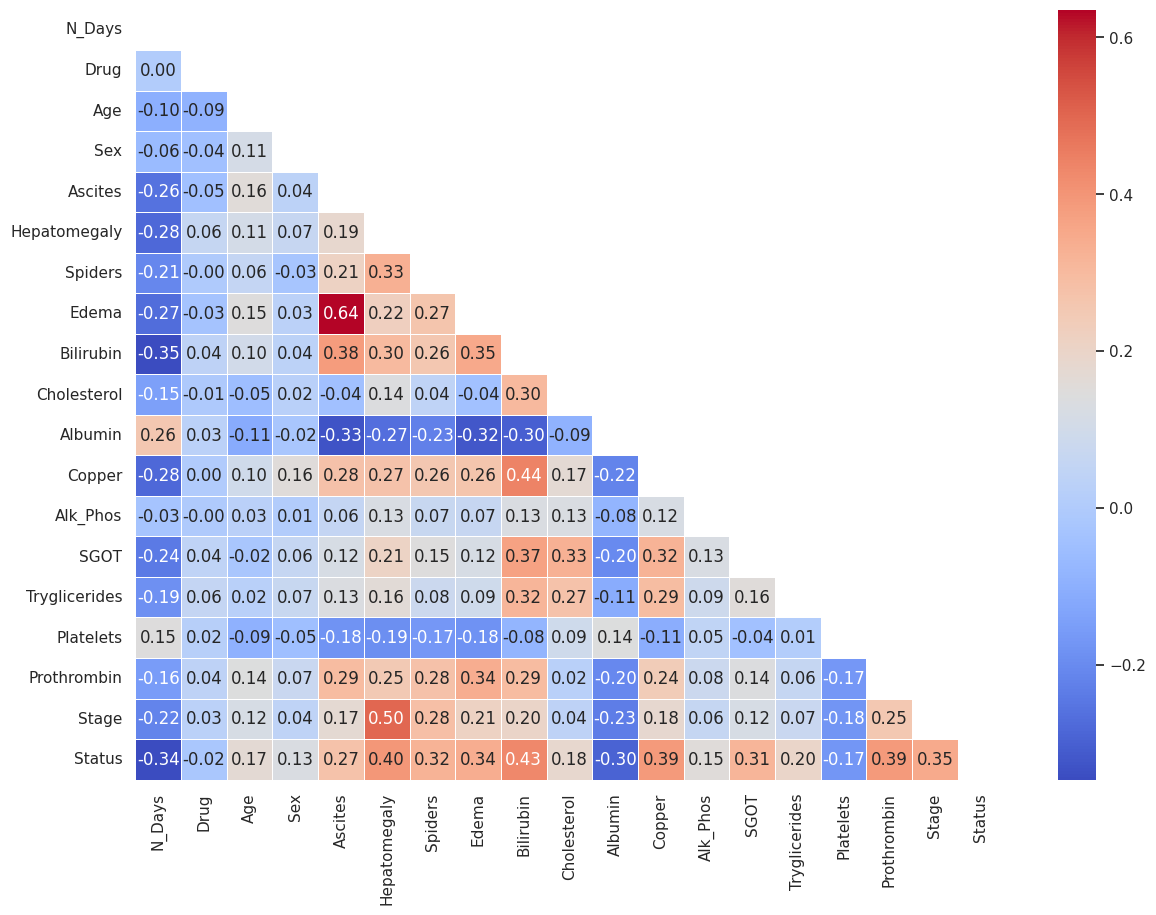

In [13]:
# Creating a heatmap
plt.figure(figsize=(14,10))
corr=train.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm',mask=np.triu(corr), linewidths=0.5, fmt=',.2f')
plt.show()

Above, we can see a heatmap showing the correlations amongst features and the target variable. At a glance, we can see that Bilirubin has the greatest positive correlation with Status at 0.43, however, this correlation is still relatively small. Conversely, N_days has the greatest negative correlation with Status at -0.34. The most notable potential correlation here is between Edema and Ascites at 0.64. 

<a id="5"></a>
# **Modeling with XGB Classifier**

In [14]:
# Splitting train dataset, removing target variable
X = train.drop(['Status'], axis=1)
y = train['Status']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Setting up XGB
x = xgb.XGBClassifier(objective='multi:softmax', num_leaves=10)

In [16]:
# Running trial to determine best parameters, Kudos to Kala Nandini for this chunk!
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': len(set(y_train)),
        'eval_metric': 'mlogloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 10),
        'subsample': trial.suggest_uniform('subsample', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)
    loss = log_loss(y_valid, y_pred_proba)
    print('Loss:', loss)
    return loss

run=0

if run==1:

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    print('Best trial:')
    trial = study.best_trial

    print('Value: {}'.format(trial.value))
    print('Params: ')
    for key, value in trial.params.items():
        print(' {}: {}'.format(key, value))

In [17]:
# Recording best parameters from trial above
best_params = {'booster': 'gbtree',
              'lambda' : 0.7450615016210775,
              'alpha' : 0.09687407078878114,
              'max_depth' : 5,
              'eta' : 0.07492961775698741,
              'gamma' : 5.495070092032152e-06,
              'colsample_bytree' : 0.3297101233951921,
              'min_child_weight' : 2.4786358814126457,
              'subsample' : 0.8537725566305738,
              'n_estimators' : 169}

In [18]:
# Creating/fitting model with best parameters
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)
print('Training Error:', log_loss(y_valid, final_model.predict_proba(X_valid)))

Training Error: 0.42699650006551926


<a id="6"></a>
# **Submission**

In [19]:
# Adding predictions to sub dataframe
preds = final_model.predict_proba(test)
sub = pd.DataFrame(test_id)
sub['Status_C'] = preds[:, 0]
sub['Status_CL'] = preds[:, 1]
sub['Status_D'] = preds[:, 2]

In [20]:
# Creating submission.cvs and viewing new dataframe
sub.to_csv('submission.csv',index=False)
sub.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.533174,0.019113,0.447713
1,7906,0.465981,0.371323,0.162696
2,7907,0.032764,0.016187,0.951049
3,7908,0.963743,0.006079,0.030178
4,7909,0.769213,0.064380,0.166407


<a id="R"></a>
# **References**

- https://www.kaggle.com/competitions/playground-series-s3e26/overview
- https://www.kaggle.com/code/iqbalsyahakbar/ps3e26-cirrhosis-classification-for-beginners#Dataset-Information
- https://www.kaggle.com/code/oscarm524/ps-s3-ep26-eda-modeling-submission
- https://www.kaggle.com/code/mattduerr/s3e26-complete-eda-3-baseline-models/notebook#1.-Exploratory-Data-Analysis
- https://www.kaggle.com/code/imnandini/multi-class-prediction-of-cirrhosis-beginner-level/notebook
- https://www.kaggle.com/code/thehustler2003/s03e26-lgbm-optuna